<a href="https://colab.research.google.com/github/MatheusElis/Estatistica-Computacional/blob/main/Exercicios/hand%20ons%201/HandOns2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Matheus Elis da Silva - Mestrado - Computação Aplicada - INPE

In [2]:
%%capture
!pip install -U kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca 
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
!pip install colorednoise
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm
import io
import plotly.io as pio
import plotly.express as px 
import plotly.graph_objects as go 
import plotly.figure_factory as ff
from scipy.stats import skew, kurtosis
pio.renderers.default = "png" 

In [6]:
import colorednoise as cn
"""
O colorenoise é um típico gerador de ruído baseado na distribuição Gaussiana com lei de potencia. 
Ref.: Timmer, J. and Koenig, M.: On generating power law noise. Astron. Astrophys. 300, 707-710 (1995) 
"""

'\nO colorenoise é um típico gerador de ruído baseado na distribuição Gaussiana com lei de potencia. \nRef.: Timmer, J. and Koenig, M.: On generating power law noise. Astron. Astrophys. 300, 707-710 (1995) \n'

## bpst (Brownian process time series)

In [8]:
def normalize_serie(serie):
    _serie = serie.copy()
    _serie = _serie - np.average(_serie)
    return _serie / np.std(_serie)

In [9]:
beta=2
dataSize = 2**10
samplePlot =2**10
bpst = cn.powerlaw_psd_gaussian(beta,dataSize)
bpst = normalize_serie(bpst)

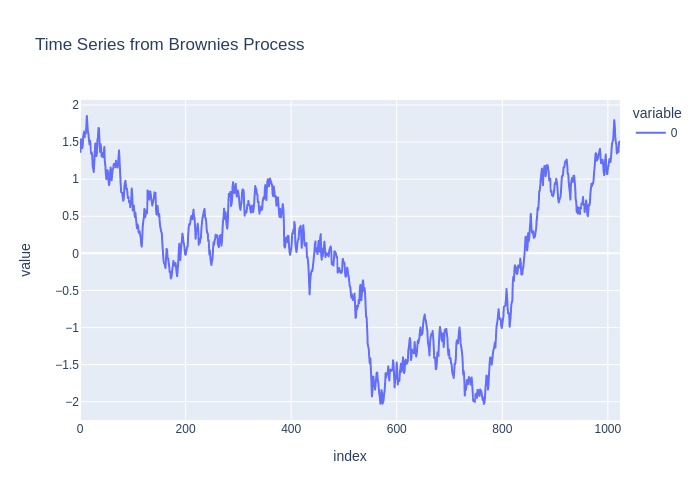

In [17]:
fig = px.line(bpst[:samplePlot], title = 'Time Series from Brownies Process')
fig.show()

## Gerador de Séries Temporais Estocásticas via P-Model

In [18]:
def next_step_1d(y, p):
    y2 = np.zeros(y.size*2)
    sign = np.random.rand(1, y.size) - 0.5
    sign /= np.abs(sign)
    y2[0:2*y.size:2] = y + sign*(1-2*p)*y
    y2[1:2*y.size+1:2] = y - sign*(1-2*p)*y
    
    return y2

def fractal_spectrum_1d(noValues, slope):
    ori_vector_size = noValues
    ori_half_size = ori_vector_size//2
    a = np.zeros(ori_vector_size)
    
    for t2 in range(ori_half_size):
        index = t2
        t4 = 1 + ori_vector_size - t2
        if (t4 >= ori_vector_size):
            t4 = t2
        coeff = (index + 1)**slope
        a[t2] = coeff
        a[t4] = coeff
        
    a[1] = 0
    
    return a

def p_model(noValues = 4096, p = 0.4999, slope = []):
    noOrders = int(np.ceil(np.log2(noValues)))
    noValuesGenerated = 2**noOrders
    
    y = np.array([1])
    for n in range(noOrders):
        y = next_step_1d(y, p)
    
    if (slope):
        fourierCoeff = fractal_spectrum_1d(noValues, slope/2)
        meanVal = np.mean(y)
        stdy = np.std(y)
        x = np.fft.ifft(y - meanVal)
        phase = np.angle(x)
        x = fourierCoeff*np.exp(1j*phase)
        x = np.fft.fft(x).real
        x *= stdy/np.std(x)
        x += meanVal
    else:
        x = y
    
    return x[0:noValues], y[0:noValues]

In [33]:
def plot_model(data, stype = True):
    if stype:
        fig = px.line(data, title = "Endogenous Series",)
    else:
        fig = px.line(data, title = "Exogenous Series")
    fig.update_traces(line=dict(width=0.3))
    return fig

In [22]:
def getSeries(slist, pinterval, betainterval, n):
  pval = np.random.uniform(pinterval[0], pinterval[1], n)
  beta = np.random.uniform(betainterval[0], betainterval[1], n)
  for i in range(0,(n)):
    x, dx = p_model(p = pval[i], slope = beta[i])
    slist.append((dx - np.mean(dx)) / np.std(dx)) 

In [23]:
N = 4 

endoList = []
exoList = []

getSeries(endoList, [0.525,0.675], [0.35,0.45], N)
getSeries(exoList, [0.675,0.975], [0.65,0.75], N)

In [27]:
endoList[0]

array([ 0.61425326, -0.00677514, -0.00677514, ..., -0.4742706 ,
       -0.4742706 , -0.31815082])

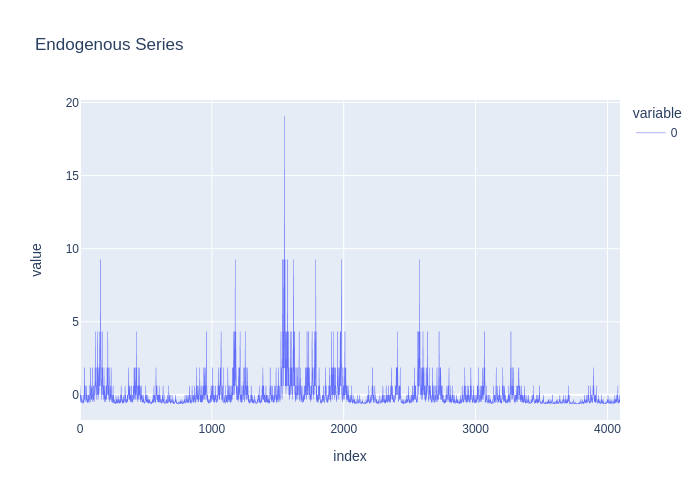

In [32]:
plot_model(endoList[0]).show()

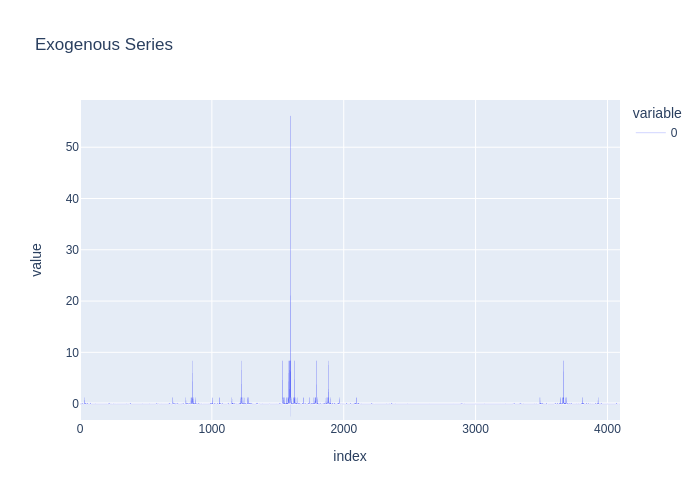

In [34]:
plot_model(exoList[0], False).show()

## 



---


## Gráfico de Cullen-Frey (GCF)

In [35]:
def cullenfrey(df):

    m=df.mean()
    std=df.std()
    s=df.skew()
    k1=df.kurtosis()
    k2=k1+3

    ss=s*s
    k=k2
    mean, std = 0, 0.1 
    samples = 4096
    A = np.random.normal(mean, std, size=samples)
    Gauss_skew = skew(A)**2
    Gauss_kurt = kurtosis(A)+3


    maior = np.max([ss, k])

    polyX1 = maior if maior > 4.4 else 4.4
    polyY1 = polyX1 + 1
    polyY2 = 3/2.*polyX1 + 3
    y_lim = polyY2 if polyY2 > 5 else 5

    x = [0, polyX1, polyX1, 0]
    y = [1, polyY1, polyY2, 3]


    poly2Y2 = 2.62*polyX1 + 3
    x2 = [0, polyX1, polyX1, 0]
    y2 = [3, polyY2, poly2Y2, 3]

    scale = 1
    fig = go.Figure(go.Scatter(x=x, y=y, fill="toself", name = "beta function"))
    fig.add_trace(go.Scatter(x=x2, y=y2, fill="toself", name = "GEV"))
    fig.update_yaxes(autorange="reversed") 
    fig.add_trace(go.Scatter(x=[Gauss_skew], y = [Gauss_kurt], mode = "markers", name = "Gaussian", marker_symbol = "star", marker_size = 15))
    for i in df.columns:
      fig.add_trace(go.Scatter(x=[ss[i]], y = [k[i]], mode = "markers", name = i+" observation"))
    fig.add_trace(go.Scatter(x=[0], y=[4.187999875999753], name="logistic", mode = "markers", marker_symbol = "x", marker_size = 15, marker_color= "black"))
    fig.add_trace(go.Scatter(x=[0], y=[1.7962675925351856], name="uniform", mode = "markers", marker_symbol = "hexagram", marker_size = 15, marker_color= "black"))
    fig.add_trace(go.Scatter(x=[4], y=[9], name="exponential", mode = "markers", marker_symbol = "circle-x", marker_size = 15, marker_color= "black"))
    fig.add_trace(go.Scatter(x = np.arange(0, polyX1, 0.1), y = 3/2. * np.arange(0, polyX1, 0.1) + 3, name="gamma", mode = "lines",  line = dict(color='black', width=4, dash='dot')))
    fig.add_trace(go.Scatter(x = np.arange(0, polyX1, 0.1), y = 2 * np.arange(0, polyX1, 0.1) + 3, name="lognormal", mode = "lines",line = dict(color='black', width=4, dash='dash')))
    fig.update_layout(
        title="Cullen-Frey graph",
        yaxis_title="Kurtosis",
        xaxis_title="Skewness²",
        legend_title="Distributions",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="black"
    )
)
    return fig


In [36]:
dfendo = pd.read_csv('https://raw.githubusercontent.com/MatheusElis/Estatistica-Computacional/main/Exercicios/hand%20ons%201/endo.csv', header = None)
dfexo = pd.read_csv('https://raw.githubusercontent.com/MatheusElis/Estatistica-Computacional/main/Exercicios/hand%20ons%201/exo.csv', header = None)


dfs = pd.concat([dfexo, dfendo], axis=1, join='inner')
dfs.columns = ["exo", "endo"]
x = dfs[ dfs["endo"] < 3*np.std(dfs["endo"]) ]["endo"]
dfs.insert(0,"endo_cut",x)
x = dfs[ dfs["exo"] < 3*np.std(dfs["exo"]) ]["exo"]
dfs.insert(0,"exo_cut",x)
dfs



,exo_cut,endo_cut,exo,endo
0,2.78590,1.02060,2.78590,1.02060
1,2.21130,0.53477,2.21130,0.53477
2,2.55760,0.53329,2.55760,0.53329
3,0.82921,0.88739,0.82921,0.88739
4,3.06160,1.59790,3.06160,1.59790
...,...,...,...,...
4091,-0.17712,1.22160,-0.17712,1.22160
4092,0.59423,0.78092,0.59423,0.78092
4093,0.81878,0.82637,0.81878,0.82637
4094,1.66360,0.80606,1.66360,0.80606


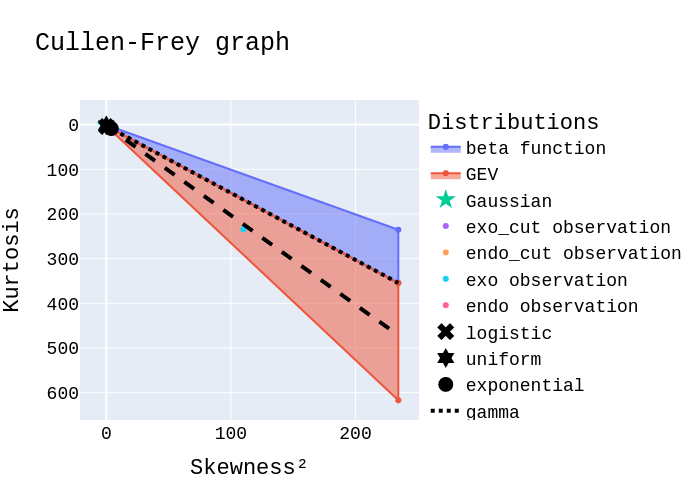

In [37]:
cullenfrey(dfs).show()

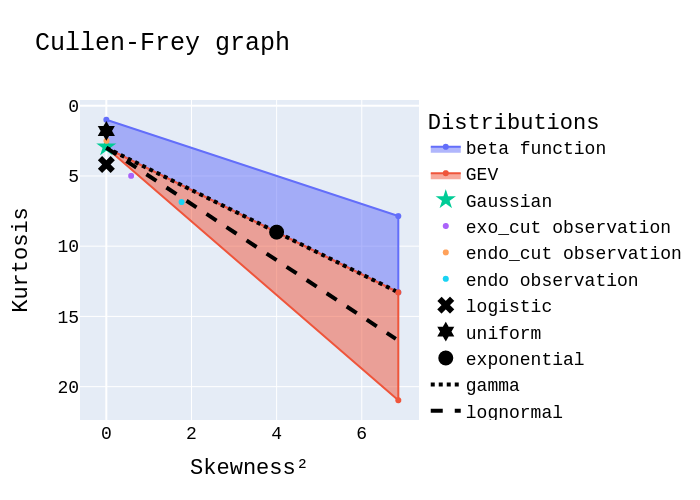

In [38]:
cullenfrey(dfs.drop(columns="exo")).show()